In [2]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

BATCH_SIZE = 128

# 加载一次数据集，保证训练模型和测试时数据集是一致的
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [3]:
SEED = 1 
NUM_CLASS = 10
# BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
### learning_rate = 1e-1 ###
LEARNING_RATE = 1e-1
### end ###
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# 统一使用交叉熵作为损失函数
criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)  
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

# 创建几个list，一个用于储存模型在测试集上的准确度（Accuracy），来衡量模型的泛化能力；一个用于储存在测试集上的损失函数的值
# 一个用于储存在训练集上的准确度；一个用于储存在训练集上的损失函数的值；
test_acc_list = []
test_loss_list = []
train_acc_list = []
train_loss_list = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    ###### 往list中添加训练集的准确度和损失函数的值 ######
    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)
    ###### end ######

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        ###### 往list中添加测试集的准确度和损失函数的值 ######
        test_acc_list.append(val_acc)
        test_loss_list.append(val_loss)
        ###### end ######
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

test_loss_list = torch.tensor(test_loss_list)
train_loss_list = torch.tensor(train_loss_list)
test_LearingRate01_Acc = np.array([tensor.item() for tensor in test_acc_list])
test_LearingRate01_loss = np.array([tensor.item() for tensor in test_loss_list])
train_LearingRate01_Acc = np.array([tensor.item() for tensor in train_acc_list])
train_LearingRate01_loss = np.array([tensor.item() for tensor in train_loss_list])
print(test_LearingRate01_Acc, test_LearingRate01_loss, train_LearingRate01_Acc, train_LearingRate01_loss)

Epoch: 1/30 Train Loss: 0.0153 Acc: 0.2643
Begin test......
Test Loss: 0.0141 Acc: 0.3384
Epoch: 2/30 Train Loss: 0.0141 Acc: 0.3314
Begin test......
Test Loss: 0.0131 Acc: 0.3906
Epoch: 3/30 Train Loss: 0.0137 Acc: 0.3601
Begin test......
Test Loss: 0.0128 Acc: 0.4125
Epoch: 4/30 Train Loss: 0.0137 Acc: 0.3607
Begin test......
Test Loss: 0.0133 Acc: 0.3805
Epoch: 5/30 Train Loss: 0.0136 Acc: 0.3618
Begin test......
Test Loss: 0.0139 Acc: 0.3844
Epoch: 6/30 Train Loss: 0.0127 Acc: 0.4081
Begin test......
Test Loss: 0.0120 Acc: 0.4499
Epoch: 7/30 Train Loss: 0.0124 Acc: 0.4219
Begin test......
Test Loss: 0.0120 Acc: 0.4475
Epoch: 8/30 Train Loss: 0.0124 Acc: 0.4253
Begin test......
Test Loss: 0.0119 Acc: 0.4446
Epoch: 9/30 Train Loss: 0.0123 Acc: 0.4266
Begin test......
Test Loss: 0.0118 Acc: 0.4628
Epoch: 10/30 Train Loss: 0.0123 Acc: 0.4290
Begin test......
Test Loss: 0.0121 Acc: 0.4483
Epoch: 11/30 Train Loss: 0.0118 Acc: 0.4512
Begin test......
Test Loss: 0.0110 Acc: 0.4965
Epoch: 1

In [4]:
SEED = 1 
NUM_CLASS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
### learning_rate = 1e-2 ###
LEARNING_RATE = 1e-2
### end ###
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# 统一使用交叉熵作为损失函数
criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)  
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

# 创建几个list，一个用于储存模型在测试集上的准确度（Accuracy），来衡量模型的泛化能力；一个用于储存在测试集上的损失函数的值
# 一个用于储存在训练集上的准确度；一个用于储存在训练集上的损失函数的值；
test_acc_list = []
test_loss_list = []
train_acc_list = []
train_loss_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    ###### 往list中添加训练集的准确度和损失函数的值 ######
    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)
    ###### end ######

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        ###### 往list中添加测试集的准确度和损失函数的值 ######
        test_acc_list.append(val_acc)
        test_loss_list.append(val_loss)
        ###### end ######
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

test_loss_list = torch.tensor(test_loss_list)
train_loss_list = torch.tensor(train_loss_list)
test_LearingRate02_Acc = np.array([tensor.item() for tensor in test_acc_list])
test_LearingRate02_loss = np.array([tensor.item() for tensor in test_loss_list])
train_LearingRate02_Acc = np.array([tensor.item() for tensor in train_acc_list])
train_LearingRate02_loss = np.array([tensor.item() for tensor in train_loss_list])
print(test_LearingRate02_Acc, test_LearingRate02_loss, train_LearingRate02_Acc, train_LearingRate02_loss)

Epoch: 1/30 Train Loss: 0.0151 Acc: 0.2842
Begin test......
Test Loss: 0.0127 Acc: 0.4078
Epoch: 2/30 Train Loss: 0.0126 Acc: 0.4043
Begin test......
Test Loss: 0.0115 Acc: 0.4630
Epoch: 3/30 Train Loss: 0.0119 Acc: 0.4437
Begin test......
Test Loss: 0.0115 Acc: 0.4814
Epoch: 4/30 Train Loss: 0.0115 Acc: 0.4645
Begin test......
Test Loss: 0.0106 Acc: 0.5227
Epoch: 5/30 Train Loss: 0.0111 Acc: 0.4814
Begin test......
Test Loss: 0.0104 Acc: 0.5192
Epoch: 6/30 Train Loss: 0.0107 Acc: 0.5058
Begin test......
Test Loss: 0.0099 Acc: 0.5582
Epoch: 7/30 Train Loss: 0.0105 Acc: 0.5144
Begin test......
Test Loss: 0.0097 Acc: 0.5629
Epoch: 8/30 Train Loss: 0.0105 Acc: 0.5196
Begin test......
Test Loss: 0.0098 Acc: 0.5604
Epoch: 9/30 Train Loss: 0.0104 Acc: 0.5217
Begin test......
Test Loss: 0.0097 Acc: 0.5657
Epoch: 10/30 Train Loss: 0.0103 Acc: 0.5245
Begin test......
Test Loss: 0.0096 Acc: 0.5733
Epoch: 11/30 Train Loss: 0.0101 Acc: 0.5340
Begin test......
Test Loss: 0.0093 Acc: 0.5868
Epoch: 1

In [5]:
SEED = 1 
NUM_CLASS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
### learning_rate = 1e-3 ###
LEARNING_RATE = 1e-3
### end ###
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# 统一使用交叉熵作为损失函数
criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)  
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

# 创建几个list，一个用于储存模型在测试集上的准确度（Accuracy），来衡量模型的泛化能力；一个用于储存在测试集上的损失函数的值
# 一个用于储存在训练集上的准确度；一个用于储存在训练集上的损失函数的值；
test_acc_list = []
test_loss_list = []
train_acc_list = []
train_loss_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    ###### 往list中添加训练集的准确度和损失函数的值 ######
    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)
    ###### end ######

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        ###### 往list中添加测试集的准确度和损失函数的值 ######
        test_acc_list.append(val_acc)
        test_loss_list.append(val_loss)
        ###### end ######
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

test_loss_list = torch.tensor(test_loss_list)
train_loss_list = torch.tensor(train_loss_list)
test_LearingRate03_Acc = np.array([tensor.item() for tensor in test_acc_list])
test_LearingRate03_loss = np.array([tensor.item() for tensor in test_loss_list])
train_LearingRate03_Acc = np.array([tensor.item() for tensor in train_acc_list])
train_LearingRate03_loss = np.array([tensor.item() for tensor in train_loss_list])
print(test_LearingRate03_Acc, test_LearingRate03_loss, train_LearingRate03_Acc, train_LearingRate03_loss)

Epoch: 1/30 Train Loss: 0.0180 Acc: 0.1000
Begin test......
Test Loss: 0.0181 Acc: 0.1012
Epoch: 2/30 Train Loss: 0.0175 Acc: 0.1426
Begin test......
Test Loss: 0.0167 Acc: 0.2242
Epoch: 3/30 Train Loss: 0.0159 Acc: 0.2609
Begin test......
Test Loss: 0.0153 Acc: 0.3057
Epoch: 4/30 Train Loss: 0.0151 Acc: 0.3013
Begin test......
Test Loss: 0.0145 Acc: 0.3469
Epoch: 5/30 Train Loss: 0.0145 Acc: 0.3267
Begin test......
Test Loss: 0.0138 Acc: 0.3686
Epoch: 6/30 Train Loss: 0.0140 Acc: 0.3479
Begin test......
Test Loss: 0.0135 Acc: 0.3817
Epoch: 7/30 Train Loss: 0.0138 Acc: 0.3514
Begin test......
Test Loss: 0.0132 Acc: 0.3910
Epoch: 8/30 Train Loss: 0.0136 Acc: 0.3623
Begin test......
Test Loss: 0.0130 Acc: 0.4008
Epoch: 9/30 Train Loss: 0.0134 Acc: 0.3695
Begin test......
Test Loss: 0.0128 Acc: 0.4083
Epoch: 10/30 Train Loss: 0.0132 Acc: 0.3760
Begin test......
Test Loss: 0.0127 Acc: 0.4125
Epoch: 11/30 Train Loss: 0.0131 Acc: 0.3807
Begin test......
Test Loss: 0.0126 Acc: 0.4190
Epoch: 1

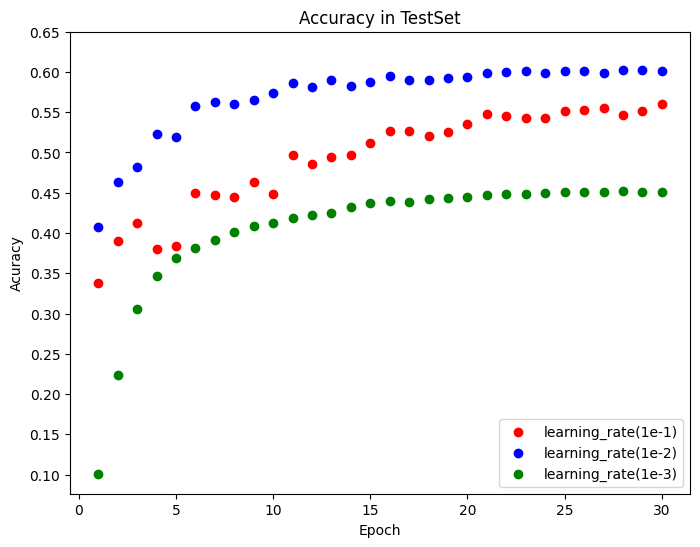

In [6]:
# 画在测试集上的Acc的图像
plt.figure(figsize=(8, 6))

x = torch.arange(1, 31)

plt.scatter(x, test_LearingRate01_Acc, color='red', label='learning_rate(1e-1)')
plt.scatter(x, test_LearingRate02_Acc, color='blue', label='learning_rate(1e-2)')
plt.scatter(x, test_LearingRate03_Acc, color='green', label='learning_rate(1e-3)')

plt.title("Accuracy in TestSet")
plt.xlabel("Epoch")
plt.ylabel("Acuracy")

plt.yticks(np.arange(0.1, 0.7, 0.05))

plt.legend()

plt.show()

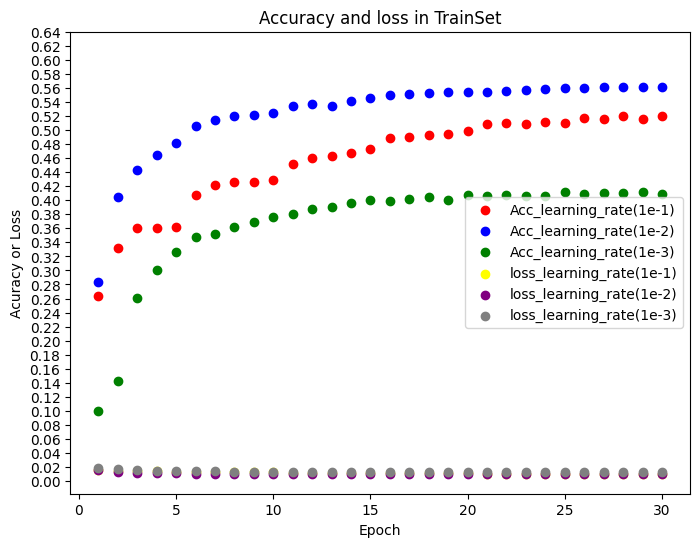

In [7]:
# 画在训练集上的Acc和loss的图像
plt.figure(figsize=(8, 6))

x = torch.arange(1, 31)

plt.scatter(x, train_LearingRate01_Acc, color='red', label='Acc_learning_rate(1e-1)')
plt.scatter(x, train_LearingRate02_Acc, color='blue', label='Acc_learning_rate(1e-2)')
plt.scatter(x, train_LearingRate03_Acc, color='green', label='Acc_learning_rate(1e-3)')
plt.scatter(x, train_LearingRate01_loss, color='yellow', label='loss_learning_rate(1e-1)')
plt.scatter(x, train_LearingRate02_loss, color='purple', label='loss_learning_rate(1e-2)')
plt.scatter(x, train_LearingRate03_loss, color='gray', label='loss_learning_rate(1e-3)')

plt.title("Accuracy and loss in TrainSet")
plt.xlabel("Epoch")
plt.ylabel("Acuracy or Loss")

plt.yticks(np.arange(0, 0.65, 0.02))

plt.legend()

plt.show()

In [8]:
SEED = 1 
NUM_CLASS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
### learning_rate ###
LEARNING_RATE = 5e-3
### end ###
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# 统一使用交叉熵作为损失函数
criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)  
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

# 创建几个list，一个用于储存模型在测试集上的准确度（Accuracy），来衡量模型的泛化能力；一个用于储存在测试集上的损失函数的值
# 一个用于储存在训练集上的准确度；一个用于储存在训练集上的损失函数的值；
test_acc_list = []
test_loss_list = []
train_acc_list = []
train_loss_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    ###### 往list中添加训练集的准确度和损失函数的值 ######
    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)
    ###### end ######

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        ###### 往list中添加测试集的准确度和损失函数的值 ######
        test_acc_list.append(val_acc)
        test_loss_list.append(val_loss)
        ###### end ######
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

test_loss_list = torch.tensor(test_loss_list)
train_loss_list = torch.tensor(train_loss_list)
test_LearingRate04_Acc = np.array([tensor.item() for tensor in test_acc_list])
test_LearingRate04_loss = np.array([tensor.item() for tensor in test_loss_list])
train_LearingRate04_Acc = np.array([tensor.item() for tensor in train_acc_list])
train_LearingRate04_loss = np.array([tensor.item() for tensor in train_loss_list])
print(test_LearingRate04_Acc, test_LearingRate04_loss, train_LearingRate04_Acc, train_LearingRate04_loss)

Epoch: 1/30 Train Loss: 0.0165 Acc: 0.2180
Begin test......
Test Loss: 0.0147 Acc: 0.3265
Epoch: 2/30 Train Loss: 0.0139 Acc: 0.3500
Begin test......
Test Loss: 0.0126 Acc: 0.4229
Epoch: 3/30 Train Loss: 0.0128 Acc: 0.4054
Begin test......
Test Loss: 0.0118 Acc: 0.4630
Epoch: 4/30 Train Loss: 0.0122 Acc: 0.4352
Begin test......
Test Loss: 0.0112 Acc: 0.4938
Epoch: 5/30 Train Loss: 0.0119 Acc: 0.4506
Begin test......
Test Loss: 0.0111 Acc: 0.4999
Epoch: 6/30 Train Loss: 0.0115 Acc: 0.4680
Begin test......
Test Loss: 0.0107 Acc: 0.5124
Epoch: 7/30 Train Loss: 0.0113 Acc: 0.4794
Begin test......
Test Loss: 0.0105 Acc: 0.5275
Epoch: 8/30 Train Loss: 0.0112 Acc: 0.4849
Begin test......
Test Loss: 0.0105 Acc: 0.5250
Epoch: 9/30 Train Loss: 0.0111 Acc: 0.4924
Begin test......
Test Loss: 0.0103 Acc: 0.5363
Epoch: 10/30 Train Loss: 0.0110 Acc: 0.4952
Begin test......
Test Loss: 0.0103 Acc: 0.5381
Epoch: 11/30 Train Loss: 0.0108 Acc: 0.5055
Begin test......
Test Loss: 0.0101 Acc: 0.5466
Epoch: 1

In [9]:
SEED = 1 
NUM_CLASS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
### learning_rate ###
LEARNING_RATE = 2e-2
### end ###
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# 统一使用交叉熵作为损失函数
criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)  
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

# 创建几个list，一个用于储存模型在测试集上的准确度（Accuracy），来衡量模型的泛化能力；一个用于储存在测试集上的损失函数的值
# 一个用于储存在训练集上的准确度；一个用于储存在训练集上的损失函数的值；
test_acc_list = []
test_loss_list = []
train_acc_list = []
train_loss_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    ###### 往list中添加训练集的准确度和损失函数的值 ######
    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)
    ###### end ######

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        ###### 往list中添加测试集的准确度和损失函数的值 ######
        test_acc_list.append(val_acc)
        test_loss_list.append(val_loss)
        ###### end ######
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

test_loss_list = torch.tensor(test_loss_list)
train_loss_list = torch.tensor(train_loss_list)
test_LearingRate05_Acc = np.array([tensor.item() for tensor in test_acc_list])
test_LearingRate05_loss = np.array([tensor.item() for tensor in test_loss_list])
train_LearingRate05_Acc = np.array([tensor.item() for tensor in train_acc_list])
train_LearingRate05_loss = np.array([tensor.item() for tensor in train_loss_list])
print(test_LearingRate05_Acc, test_LearingRate05_loss, train_LearingRate05_Acc, train_LearingRate05_loss)

Epoch: 1/30 Train Loss: 0.0145 Acc: 0.3150
Begin test......
Test Loss: 0.0119 Acc: 0.4470
Epoch: 2/30 Train Loss: 0.0124 Acc: 0.4252
Begin test......
Test Loss: 0.0111 Acc: 0.4941
Epoch: 3/30 Train Loss: 0.0118 Acc: 0.4524
Begin test......
Test Loss: 0.0107 Acc: 0.5048
Epoch: 4/30 Train Loss: 0.0115 Acc: 0.4720
Begin test......
Test Loss: 0.0103 Acc: 0.5240
Epoch: 5/30 Train Loss: 0.0113 Acc: 0.4798
Begin test......
Test Loss: 0.0108 Acc: 0.5038
Epoch: 6/30 Train Loss: 0.0108 Acc: 0.5018
Begin test......
Test Loss: 0.0099 Acc: 0.5467
Epoch: 7/30 Train Loss: 0.0107 Acc: 0.5125
Begin test......
Test Loss: 0.0098 Acc: 0.5499
Epoch: 8/30 Train Loss: 0.0106 Acc: 0.5135
Begin test......
Test Loss: 0.0097 Acc: 0.5591
Epoch: 9/30 Train Loss: 0.0105 Acc: 0.5202
Begin test......
Test Loss: 0.0098 Acc: 0.5537
Epoch: 10/30 Train Loss: 0.0104 Acc: 0.5253
Begin test......
Test Loss: 0.0096 Acc: 0.5708
Epoch: 11/30 Train Loss: 0.0102 Acc: 0.5367
Begin test......
Test Loss: 0.0093 Acc: 0.5871
Epoch: 1

In [10]:
SEED = 1 
NUM_CLASS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
### learning_rate ###
LEARNING_RATE = 4e-2
### end ###
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# 统一使用交叉熵作为损失函数
criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)  
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

# 创建几个list，一个用于储存模型在测试集上的准确度（Accuracy），来衡量模型的泛化能力；一个用于储存在测试集上的损失函数的值
# 一个用于储存在训练集上的准确度；一个用于储存在训练集上的损失函数的值；
test_acc_list = []
test_loss_list = []
train_acc_list = []
train_loss_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    ###### 往list中添加训练集的准确度和损失函数的值 ######
    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)
    ###### end ######

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        ###### 往list中添加测试集的准确度和损失函数的值 ######
        test_acc_list.append(val_acc)
        test_loss_list.append(val_loss)
        ###### end ######
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

test_loss_list = torch.tensor(test_loss_list)
train_loss_list = torch.tensor(train_loss_list)
test_LearingRate06_Acc = np.array([tensor.item() for tensor in test_acc_list])
test_LearingRate06_loss = np.array([tensor.item() for tensor in test_loss_list])
train_LearingRate06_Acc = np.array([tensor.item() for tensor in train_acc_list])
train_LearingRate06_loss = np.array([tensor.item() for tensor in train_loss_list])
print(test_LearingRate06_Acc, test_LearingRate06_loss, train_LearingRate06_Acc, train_LearingRate06_loss)

Epoch: 1/30 Train Loss: 0.0144 Acc: 0.3209
Begin test......
Test Loss: 0.0123 Acc: 0.4287
Epoch: 2/30 Train Loss: 0.0127 Acc: 0.4008
Begin test......
Test Loss: 0.0122 Acc: 0.4407
Epoch: 3/30 Train Loss: 0.0122 Acc: 0.4317
Begin test......
Test Loss: 0.0109 Acc: 0.4960
Epoch: 4/30 Train Loss: 0.0120 Acc: 0.4474
Begin test......
Test Loss: 0.0108 Acc: 0.5093
Epoch: 5/30 Train Loss: 0.0118 Acc: 0.4525
Begin test......
Test Loss: 0.0111 Acc: 0.4933
Epoch: 6/30 Train Loss: 0.0111 Acc: 0.4896
Begin test......
Test Loss: 0.0107 Acc: 0.5196
Epoch: 7/30 Train Loss: 0.0110 Acc: 0.4937
Begin test......
Test Loss: 0.0103 Acc: 0.5335
Epoch: 8/30 Train Loss: 0.0108 Acc: 0.5017
Begin test......
Test Loss: 0.0101 Acc: 0.5435
Epoch: 9/30 Train Loss: 0.0108 Acc: 0.5035
Begin test......
Test Loss: 0.0102 Acc: 0.5354
Epoch: 10/30 Train Loss: 0.0108 Acc: 0.5063
Begin test......
Test Loss: 0.0099 Acc: 0.5506
Epoch: 11/30 Train Loss: 0.0103 Acc: 0.5301
Begin test......
Test Loss: 0.0096 Acc: 0.5709
Epoch: 1

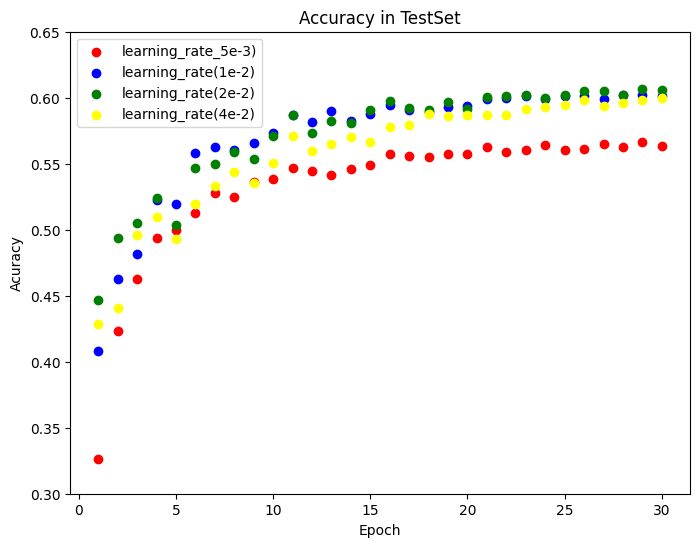

In [11]:
# 画补充的learning rate在测试集上的Acc的图像
plt.figure(figsize=(8, 6))

x = torch.arange(1, 31)

plt.scatter(x, test_LearingRate04_Acc, color='red', label='learning_rate_5e-3)')
plt.scatter(x, test_LearingRate02_Acc, color='blue', label='learning_rate(1e-2)')
plt.scatter(x, test_LearingRate05_Acc, color='green', label='learning_rate(2e-2)')
plt.scatter(x, test_LearingRate06_Acc, color='yellow', label='learning_rate(4e-2)')

plt.title("Accuracy in TestSet")
plt.xlabel("Epoch")
plt.ylabel("Acuracy")

plt.yticks(np.arange(0.3, 0.7, 0.05))

plt.legend()

plt.show()